In [1]:
import os
from collections import defaultdict
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from tensorflow.keras import Model, Input

In [2]:

# Path to the directory containing the images
image_directory = r'C:\Users\tanmayee patil\Downloads\Dataset - Copy'

# Load images from the directory
def load_images_from_directory(directory, target_size):
    images = []
    labels = []
    filenames = []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                if filename.endswith((".png", ".jpg", ".jpeg")):
                    image_path = os.path.join(class_dir, filename)
                    try:
                        image = Image.open(image_path).convert("RGB")
                        image = image.resize((target_size, target_size))
                        images.append(np.array(image))
                        labels.append(label)
                        filenames.append(f"{class_name}/{filename}")  # Append class name and filename
                    except Exception as e:
                        print(f"Error loading image {filename} from {class_name}: {e}")
    return np.array(images), np.array(labels), class_names, filenames

# Load images
x_data, y_data, class_names, filenames = load_images_from_directory(image_directory, 32)
input_shape = (32, 32, 3)

In [3]:

# Debugging print statements
print("Found class names:", class_names)
print("Loaded images shape:", x_data.shape)
print("Loaded labels shape:", y_data.shape)
print("Sample labels:", y_data[:10])


Found class names: ['Ses01M_script03_1', 'Ses02F_script03_2', 'Ses02M_impro01', 'Ses03M_impro04', 'Ses04F_script03_2', 'Ses04M_impro01', 'Ses05M_impro06']
Loaded images shape: (1678, 32, 32, 3)
Loaded labels shape: (1678,)
Sample labels: [0 0 0 0 0 0 0 0 0 0]


In [4]:

# Define the number of clusters and other hyperparameters
num_clusters = 20
k_neighbours = 5
representation_dim = 512
projection_units = 128
tune_encoder_during_clustering = False

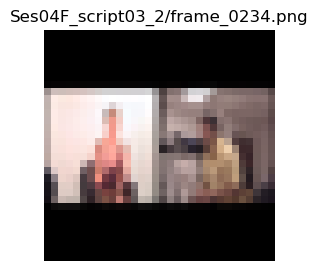

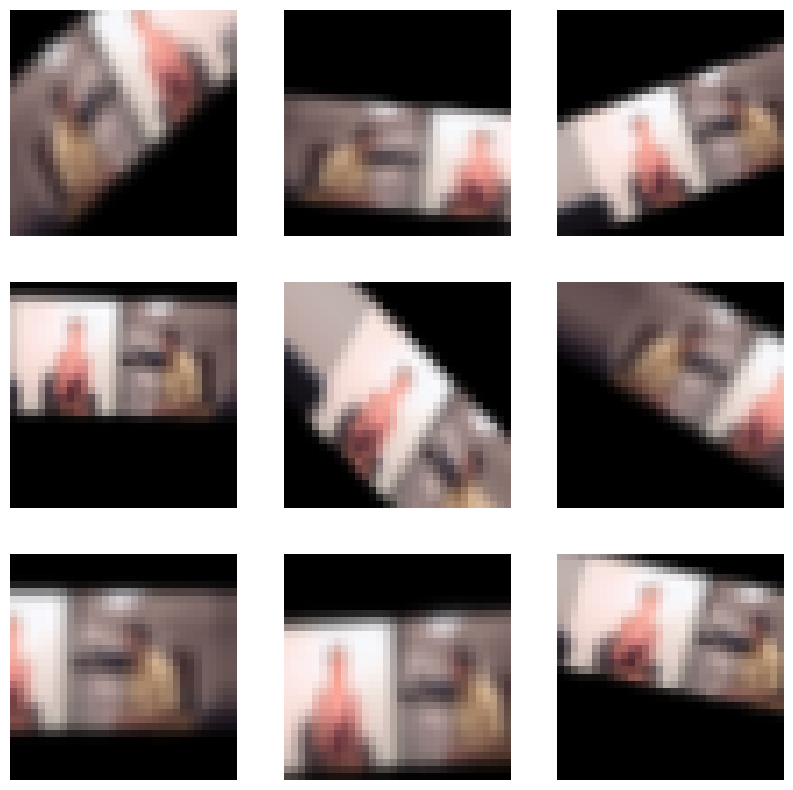

In [5]:
# Define preprocessing and augmentation layers
data_preprocessing = keras.Sequential(
    [
        layers.Resizing(32, 32),
        layers.Normalization(),
    ]
)
data_preprocessing.layers[-1].adapt(x_data)

data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(
            height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="nearest"
        ),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(factor=0.15, fill_mode="nearest"),
        layers.RandomZoom(
            height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode="nearest"
        ),
    ]
)

# Display original and augmented images
image_idx = np.random.choice(range(x_data.shape[0]))
image = x_data[image_idx]
plt.figure(figsize=(3, 3))
plt.imshow(image.astype("uint8"))
plt.title(filenames[image_idx])
_ = plt.axis("off")

# Display augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_images = data_augmentation(np.array([image]))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

plt.show()

In [6]:

def create_encoder(representation_dim, input_shape=(32, 32, 3)):
    sequential_encoder = tf.keras.Sequential(
        [
            tf.keras.applications.ResNet50V2(
                include_top=False, weights=None, pooling="avg", input_shape=input_shape
            ),
            layers.Dense(representation_dim),
        ]
    )
    
    # Convert Sequential model to Functional model
    input_layer = Input(shape=input_shape)
    output_layer = sequential_encoder(input_layer)
    functional_encoder = Model(inputs=input_layer, outputs=output_layer)
    
    return functional_encoder

# Define parameters
representation_dim = 128  # Example value
projection_units = 64  # Example value
input_shape = (32, 32, 3)  # Example input shape


In [7]:
class RepresentationLearner(keras.Model):
    def __init__(self, encoder, projection_units, num_augmentations, temperature=1.0, dropout_rate=0.1, l2_normalize=False, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.projector = keras.Sequential(
            [
                layers.Dropout(dropout_rate),
                layers.Dense(units=projection_units, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
            ]
        )
        self.num_augmentations = num_augmentations
        self.temperature = temperature
        self.l2_normalize = l2_normalize
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_contrastive_loss(self, feature_vectors, batch_size):
        num_augmentations = tf.shape(feature_vectors)[0] // batch_size
        if self.l2_normalize:
            feature_vectors = tf.nn.l2_normalize(feature_vectors, axis=1)
        logits = tf.matmul(feature_vectors, feature_vectors, transpose_b=True) / self.temperature
        logits_max = tf.reduce_max(logits, axis=1, keepdims=True)
        logits = logits - logits_max
        targets = tf.tile(tf.eye(batch_size), [num_augmentations, num_augmentations])
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=targets, logits=logits)
        return tf.reduce_mean(loss)

    def call(self, inputs):
        preprocessed = data_preprocessing(inputs)
        augmented = []
        for _ in range(self.num_augmentations):
            augmented.append(data_augmentation(preprocessed))
        augmented = tf.concat(augmented, axis=0)
        features = self.encoder(augmented)
        return self.projector(features)

    def train_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        with tf.GradientTape() as tape:
            feature_vectors = self(inputs, training=True)
            loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        feature_vectors = self(inputs, training=False)
        loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


In [9]:
tune_encoder_during_clustering = True  # Example flag

# Create encoder and representation learner
encoder = create_encoder(representation_dim, input_shape)
representation_learner = RepresentationLearner(encoder, projection_units, num_augmentations=2, temperature=0.1)

# Cosine decay learning rate scheduler
lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=500, alpha=0.1
)

# Compile the model
representation_learner.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001),
)

# Fit the model
history = representation_learner.fit(
    x=x_data,
    batch_size=512,
    epochs=10
)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 160s 26s/step - loss: 265.4775
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 115s 27s/step - loss: 109.9543
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 119s 27s/step - loss: 56.4500
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 126s 29s/step - loss: 29.3725
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 112s 26s/step - loss: 17.4437
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 112s 26s/step - loss: 13.7889
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 112s 26s/step - loss: 12.2977
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 123s 29s/step - loss: 11.9467
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 116s 27s/step - loss: 11.9815
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 127s 29s/step - loss: 12.2163


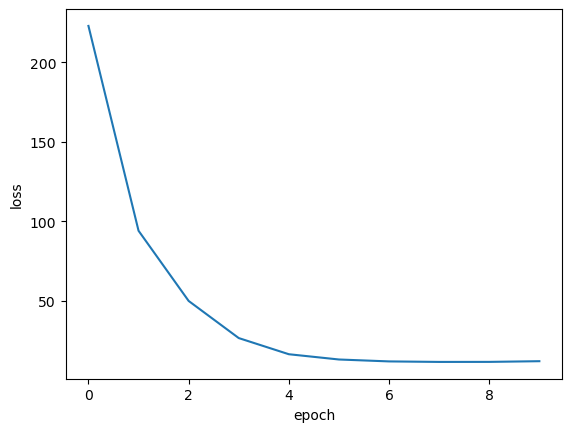

In [10]:

plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [11]:
# Generate feature vectors
batch_size = 500
feature_vectors = encoder.predict(x_data, batch_size=batch_size, verbose=1)
feature_vectors = tf.keras.utils.normalize(feature_vectors)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step  


In [14]:
# Find nearest neighbours
neighbours = []
num_batches = feature_vectors.shape[0] // batch_size
for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = feature_vectors[start_idx:end_idx]
    similarities = tf.matmul(current_batch, feature_vectors, transpose_b=True)
    _, indices = tf.nn.top_k(similarities, k=k_neighbours + 1, sorted=True)
    neighbours.append(indices[:, 1:])

neighbours = np.reshape(np.array(neighbours), (-1, k_neighbours))


100%|██████████| 3/3 [00:00<00:00, 114.13it/s]


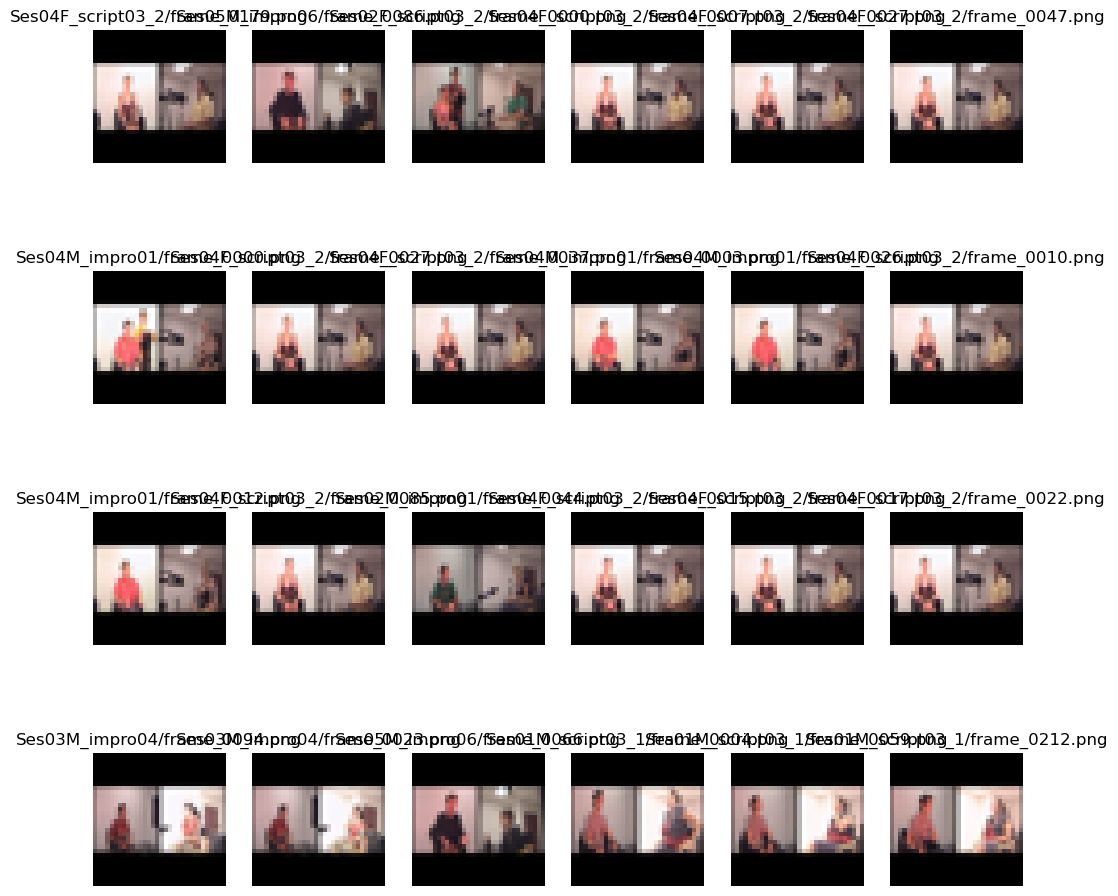

In [15]:

nrows = 4
ncols = k_neighbours + 1
plt.figure(figsize=(12, 12))
position = 1
for _ in range(nrows):
    anchor_idx = np.random.choice(range(1501))
    neighbour_indices = neighbours[anchor_idx]
    indices = [anchor_idx] + neighbour_indices.tolist()
    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        plt.imshow(x_data[indices[j]].astype("uint8"))
        plt.title(filenames[indices[j]])
        plt.axis("off")
        position += 1

In [16]:
# Define a placeholder for ClustersConsistencyLoss
class ClustersConsistencyLoss(layers.Layer):
    def __init__(self, **kwargs):
        super(ClustersConsistencyLoss, self).__init__(**kwargs)

    def call(self, inputs):
        # Add your custom loss computation here
        return tf.reduce_mean(inputs)

In [17]:
class ClustersEntropyLoss(tf.keras.losses.Loss):
    def _init_(self, entropy_loss_weight=1.0):
        super()._init_()
        self.entropy_loss_weight = entropy_loss_weight

    def call(self, target, cluster_probabilities):
        num_clusters = tf.cast(tf.shape(cluster_probabilities)[-1], tf.float32)
        target = tf.math.log(num_clusters)
        cluster_probabilities = tf.reduce_mean(cluster_probabilities, axis=0)
        cluster_probabilities = tf.clip_by_value(cluster_probabilities, 1e-8, 1.0)
        entropy = -tf.reduce_sum(cluster_probabilities * tf.math.log(cluster_probabilities))
        loss = target - entropy
        return loss

In [23]:
# Define the ClusteringLayer
class ClusteringLayer(layers.Layer):
    def __init__(self, clustering_model, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.clustering_model = clustering_model

    def call(self, inputs):
        return self.clustering_model(inputs)

# Define the CustomSimilarityLayer to handle the TensorFlow operation
class CustomSimilarityLayer(layers.Layer):
    def call(self, inputs):
        cluster_probabilities = inputs
        # Add print statement to debug the shape of cluster_probabilities
        print("Shape of cluster_probabilities:", cluster_probabilities.shape)
        
        # Compute pairwise similarities using dot product
        expanded_a = tf.expand_dims(cluster_probabilities, 1)  # Shape: (batch_size, 1, num_clusters)
        expanded_b = tf.expand_dims(cluster_probabilities, 2)  # Shape: (batch_size, num_clusters, 1)
        similarities = tf.matmul(expanded_a, expanded_b)  # Shape: (batch_size, num_clusters, num_clusters)
        
        return tf.reduce_mean(similarities, axis=-1)

# Function to create the clustering learner
def create_clustering_learner(clustering_model):
    inputs = Input(shape=(32, 32, 3), name="input_image")
    cluster_probabilities = ClusteringLayer(clustering_model, name="cluster_probabilities")(inputs)
    similarities = CustomSimilarityLayer(name="similarities")(cluster_probabilities)
    clusters_consistency_loss = ClustersConsistencyLoss(name="clusters_consistency_loss")(similarities)
    return Model(inputs=inputs, outputs=[cluster_probabilities, similarities, clusters_consistency_loss])


# Placeholder for create_clustering_model function
def create_clustering_model(encoder, num_clusters):
    # Define the clustering model here
    inputs = Input(shape=(32, 32, 3), name="input_image")
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(num_clusters, activation='softmax')(x)
    return Model(inputs=inputs, outputs=outputs, name="clustering_model")

# Example usage
encoder = None  # Define or load your encoder here
num_clusters = 10  # Set the number of clusters

clustering_model = create_clustering_model(encoder, num_clusters)
clustering_learner = create_clustering_learner(clustering_model)

# Print model summary to debug the outputs
clustering_learner.summary()

tune_encoder_during_clustering = True  # Example flag
if tune_encoder_during_clustering:
    clustering_learner.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss={
            "cluster_probabilities": "categorical_crossentropy",
            "similarities": "mse",
            "clusters_consistency_loss": "mse"
        }
    )

# Assuming x_data and neighbours are defined correctly
# Example dummy data for demonstration
x_data = np.random.rand(100, 32, 32, 3)  # 100 samples of 32x32x3 images
k_neighbours = 5  # Example number of neighbors
neighbours = np.random.randint(0, 100, size=(100, k_neighbours))  # 100 samples with 5 neighbours each

# Prepare the input data dictionary for the fit method
input_data = {
    "input_image": x_data,
    **{f"neighbour_{idx}": x_data[neighbours[:, idx]] for idx in range(k_neighbours)}
}

# Dummy target data for unsupervised learning
dummy_target_data = {
    "cluster_probabilities": np.zeros((100, num_clusters)),
    "similarities": np.zeros((100, num_clusters)),
    "clusters_consistency_loss": np.zeros((100,))
}

# Verify shapes
for key, value in input_data.items():
    print(f"{key}: {value.shape}")

# Call the fit method
clustering_learner.fit(
    x=input_data,
    y=dummy_target_data,
    batch_size=32,
    epochs=5,
)

Shape of cluster_probabilities: (None, 10)


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cluster_probabilities           │ (None, 10)             │        72,906 │
│ (ClusteringLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ similarities                    │ (None, 1)              │             0 │
│ (CustomSimilarityLayer)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clusters_consistency_loss       │ ()                     │             0 │
│ (ClustersConsistencyLoss)       │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,906 (284.79 KB)

 Trainable params: 72,906 (284.79 KB)

 Non-trainable params: 0 (0.00 B)

input_image: (100, 32, 32, 3)
neighbour_0: (100, 32, 32, 3)
neighbour_1: (100, 32, 32, 3)
neighbour_2: (100, 32, 32, 3)
neighbour_3: (100, 32, 32, 3)
neighbour_4: (100, 32, 32, 3)
Epoch 1/5
Shape of cluster_probabilities: (None, 10)
Shape of cluster_probabilities: (None, 10)
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0224
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0223
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0224
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0225
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0226


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster 0 label is: Class 9 - accuracy: 40.0%
Cluster 1 label is: Class 2 - accuracy: 40.0%
Cluster 2 label is: Class 3 - accuracy: 23.08%
Cluster 3 label is: Class 1 - accuracy: 33.33%
Cluster 4 label is: Class 7 - accuracy: 28.57%
Cluster 5 label is: Class 3 - accuracy: 17.65%
Cluster 6 label is: Class 4 - accuracy: 37.5%
Cluster 7 label is: Class 1 - accuracy: 22.22%
Cluster 8 label is: Class 4 - accuracy: 21.43%
Cluster 9 label is: Class 6 - accuracy: 66.67%


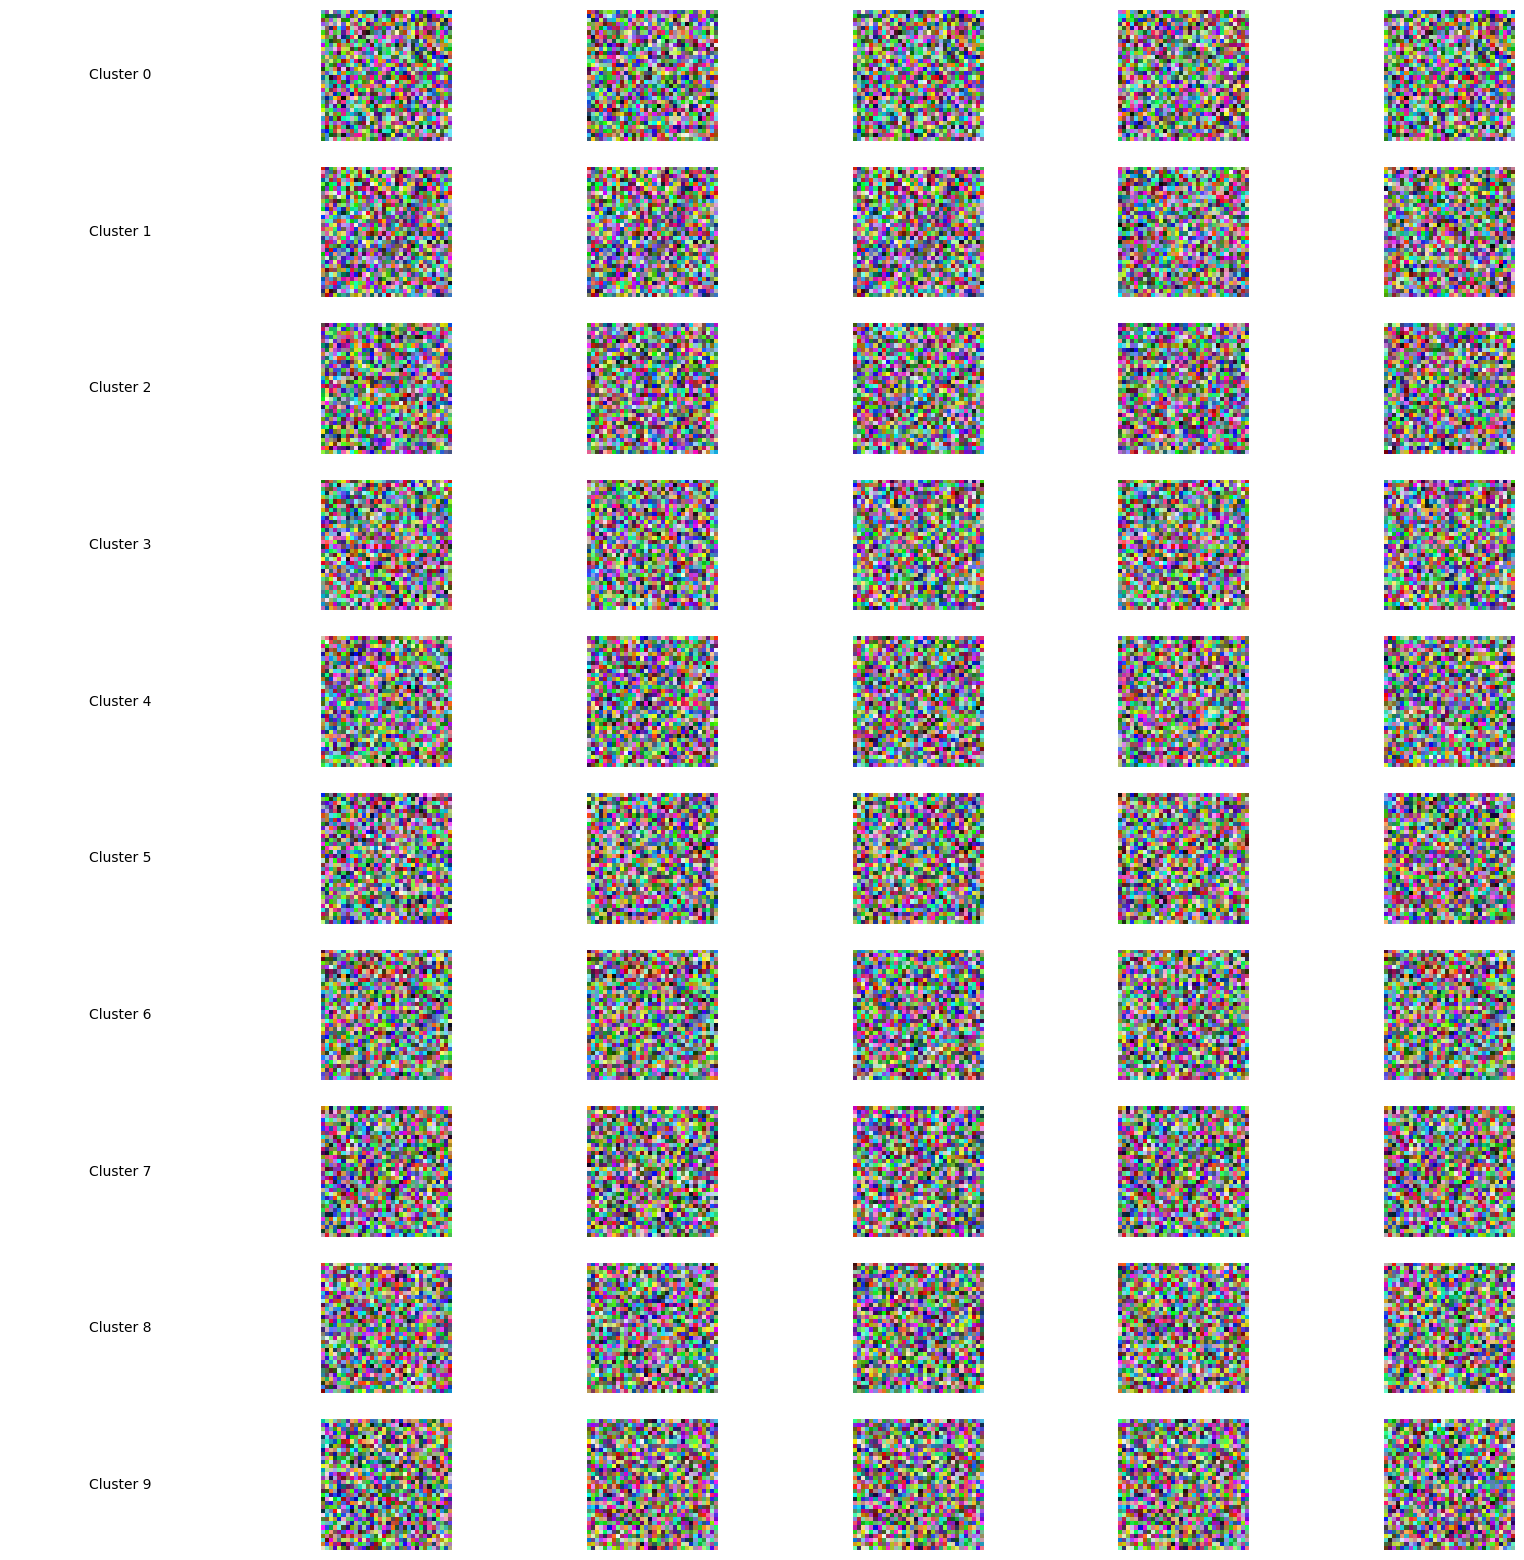

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import KMeans  # Example clustering algorithm

# Assuming x_data is your dataset and y_data contains the labels
x_data = np.random.rand(100, 32, 32, 3)  # Example data, replace with your actual data
y_data = np.random.randint(0, 10, (100, 1))  # Example labels, replace with your actual labels
classes = [f"Class {i}" for i in range(10)]  # Example class names, replace with your actual class names
num_classes = len(classes)

# Flatten the image data if necessary for clustering
x_data_flattened = x_data.reshape(x_data.shape[0], -1)

# Define and fit your clustering model
num_clusters = 10
clustering_model = KMeans(n_clusters=num_clusters)
clusters = clustering_model.fit_predict(x_data_flattened)

# Map clusters to images
clusters_to_images = defaultdict(list)
for idx, cluster in enumerate(clusters):
    clusters_to_images[cluster].append(idx)

# Calculate and print cluster label counts and accuracies
cluster_label_counts = defaultdict(lambda: [0] * num_classes)

for c in range(num_clusters):
    for idx in clusters_to_images[c]:
        cluster_label_counts[c][y_data[idx][0]] += 1

    cluster_label_idx = np.argmax(cluster_label_counts[c])
    correct_count = np.max(cluster_label_counts[c])
    cluster_size = len(clusters_to_images[c])
    accuracy = np.round((correct_count / cluster_size) * 100, 2) if cluster_size > 0 else 0
    cluster_label = classes[cluster_label_idx]
    print(f"Cluster {c} label is: {cluster_label} - accuracy: {accuracy}%")

# Plotting clusters and sample images
num_clusters_to_display = num_clusters  # Change as needed
images_per_cluster = 5  # Number of images to display per cluster

plt.figure(figsize=(20, 20))
for cluster in range(num_clusters_to_display):
    # Skip empty clusters
    if len(clusters_to_images[cluster]) == 0:
        print(f"Cluster {cluster} is empty. Skipping.")
        continue
    
    plt.subplot(num_clusters_to_display, images_per_cluster + 1, cluster * (images_per_cluster + 1) + 1)
    plt.text(0.5, 0.5, f"Cluster {cluster}", horizontalalignment="center", verticalalignment="center")
    plt.axis("off")

    image_indices = np.random.choice(clusters_to_images[cluster], images_per_cluster)
    for col, image_idx in enumerate(image_indices):
        plt.subplot(num_clusters_to_display, images_per_cluster + 1, cluster * (images_per_cluster + 1) + 2 + col)
        plt.imshow(x_data[image_idx])
        plt.axis("off")

plt.show()
